[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/latent-variable-models/latent_variable_models_part_1.ipynb)

In [ ]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/latent-variable-models/latent_variable_models_util.py
    # Install additional dependencies
    !pip install daft==0.1.0
except:
    pass

# Latent variable models, part 1: Gaussian mixture models and the EM algorithm

This is part 1 of a two-part series of articles about latent variable models. Part 1 covers the expectation maximization (EM) algorithm and its application to Gaussian mixture models. [Part 2](latent_variable_models_part_2.ipynb) covers approximate inference and variational autoencoders.

## Introduction

Given a probabilistic model $p(\mathbf{x} \lvert \boldsymbol{\theta})$ and $N$ observations $\mathbf{X} = \left\{ \mathbf{x}_1, \ldots, \mathbf{x}_N \right\}$ we often want to find a value for parameter $\boldsymbol{\theta}$ that maximizes the likelihood function $p(\mathbf{X} \lvert \boldsymbol{\theta})$, a function of parameter $\boldsymbol{\theta}$. This is known as [maximimum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE). 

$$
\boldsymbol{\theta}_{MLE} = \underset{\boldsymbol{\theta}}{\mathrm{argmax}} p(\mathbf{X} \lvert \boldsymbol{\theta})
\tag{1}
$$

If the model is a simple probability distribution, like a single Gaussian, for example, then $\boldsymbol{\theta}_{MLE} = \left\{ \boldsymbol{\mu}_{MLE}, \boldsymbol{\Sigma}_{MLE} \right\}$ has an analytical solution. A common approach for more complex models is *gradient descent* using the *negative log likelihood*, $-\log p(\mathbf{X} \lvert \boldsymbol{\theta})$, as loss function. This can easily be implemented with frameworks like PyTorch or Tensorflow provided that $p(\mathbf{X} \lvert \boldsymbol{\theta})$ is differentiable w.r.t. $\boldsymbol{\theta}$. But this is not necessarily the most efficient approach.

## Gaussian mixture model

MLE can often be simplified by introducing *latent variables*. A latent variable model makes the assumption that an observation $\mathbf{x}_i$ is caused by some underlying latent variable, a variable that cannot be observed directly but can be inferred from observed variables and parameters. For example, the following plot shows observations in 2-dimensional space and one can see that their overall distribution doesn't seem follow a simple distribution like a single Gaussian.

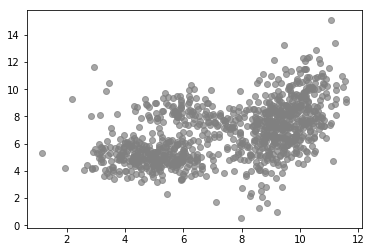

In [1]:
from latent_variable_models_util import n_true, mu_true, sigma_true
from latent_variable_models_util import generate_data, plot_data, plot_densities

%matplotlib inline

X, T = generate_data(n=n_true, mu=mu_true, sigma=sigma_true)

plot_data(X, color='grey')

But we can see that there are clusters of higher density. Also, the distribution within a cluster looks more like a Gaussian compared to the overall distribution. Indeed, these data were generated using a *mixture* of three Gaussians as shown in the following plot.

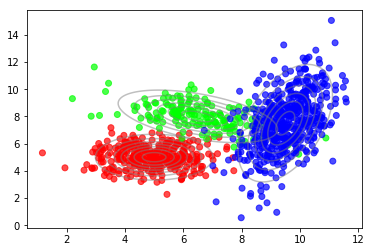

In [2]:
plot_data(X, color=T)
plot_densities(X, mu=mu_true, sigma=sigma_true)

The underlying probabilistic model is called a *Gaussian mixture model* (GMM), a weighted sum of $C$ Gaussian components where $C=3$ in this example.

$$
p(\mathbf{x} \lvert \boldsymbol{\theta}) = \sum_{c=1}^{C} \pi_c \mathcal{N}(\mathbf{x} \lvert \boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c)
\tag{2}
$$

$\pi_c$, $\boldsymbol{\mu}_{c}$ and $\boldsymbol{\Sigma}_{c}$ are the weight, mean vector and covariance matrix of mixture component $c$, respectively. The weights are non-negative and sum up to $1$ i.e. $\sum_{c=1}^{C} \pi_c = 1$. Parameter vector $\boldsymbol{\theta} = \left\{ \pi_1, \boldsymbol{\mu}_{1}, \boldsymbol{\Sigma}_{1}, \ldots, \pi_C, \boldsymbol{\mu}_{C}, \boldsymbol{\Sigma}_{C} \right\}$ denotes the set of all model parameters. If we introduce a discrete latent variable $\mathbf{t}$ that determines the assignment of observations to mixture components we can define a joint distribution over observed and latent variables $p(\mathbf{x}, \mathbf{t} \lvert \boldsymbol{\theta})$ in terms of a conditional distribution $p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta})$ and a prior distribution $p(\mathbf{t} \lvert \boldsymbol{\theta})$

$$
p(\mathbf{x}, \mathbf{t} \lvert \boldsymbol{\theta}) = p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta}) p(\mathbf{t} \lvert \boldsymbol{\theta})
\tag{3}
$$

where $p(\mathbf{x} \lvert t_c = 1, \boldsymbol{\theta}) = \mathcal{N}(\mathbf{x} \lvert \boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c)$ and $p(t_c = 1 \lvert \boldsymbol{\theta}) = \pi_c$. The values of $\mathbf{t}$ are one-hot encoded. For example, $t_2 = 1$ refers to the second mixture component  which means $\mathbf{t} = (0,1,0)^T$ if there are $C=3$ components in total. The marginal distribution $p(\mathbf{x} \lvert \boldsymbol{\theta})$ is obtained by summing over all possible states of $\mathbf{t}$.

$$
\begin{align*}
p(\mathbf{x} \lvert \boldsymbol{\theta}) &= 
\sum_{c=1}^{C} p(t_c = 1 \lvert \boldsymbol{\theta}) p(\mathbf{x} \lvert t_c = 1, \boldsymbol{\theta}) \\ &= 
\sum_{c=1}^{C} \pi_c \mathcal{N}(\mathbf{x} \lvert \boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c)
\tag{4}
\end{align*}
$$

For each observation $\mathbf{x}_i$ we have one latent variable $\mathbf{t}_i$, as shown in the following plate notation of the model.

![gmm](images/gmm/gmm.png)

We denote the set of all observations by $\mathbf{X}$ and the set of all latent variables by $\mathbf{T}$. If we could observe $\mathbf{T}$ directly, we could easily maximize the *complete-data likelihood* $p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})$ because we would then know the assignment of data points to components, and fitting a single Gaussian per component can be done analytically. But since we can only observe $\mathbf{X}$, we have to maximize the *marginal likelihood* or *incomplete-data likelihood* $p(\mathbf{X} \lvert \boldsymbol{\theta})$. By using the logarithm of the likelihood we have 

$$
\begin{align*}
\boldsymbol{\theta}_{MLE} &= 
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \log p(\mathbf{X} \lvert \boldsymbol{\theta}) \\ &=
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \log \sum_{T} p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})
\tag{5}
\end{align*}
$$

which involves a summation over latent variables inside the logarithm. This prevents a simple analytical solution to the optimization problem. 

## Expectation maximization algorithm

Although we cannot observe latent variables directly, we can obtain their posterior distribution. We start with a preliminary parameter value $\boldsymbol{\theta}^{old}$.

$$
p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}^{old}) = {
{p(\mathbf{X} \lvert \mathbf{T}, \boldsymbol{\theta}^{old}) p(\mathbf{T} \lvert \boldsymbol{\theta}^{old})} \over 
{\sum_{T} p(\mathbf{X} \lvert \mathbf{T}, \boldsymbol{\theta}^{old}) p(\mathbf{T} \lvert \boldsymbol{\theta}^{old})}}
\tag{6}
$$

This allows us to define an *<ins>e</ins>xpectation* of the complete-data likelihood w.r.t. to the posterior distribution. 

$$
\begin{align*}
\mathcal{Q}(\boldsymbol{\theta}, \boldsymbol{\theta}^{old}) &= 
\sum_{T} p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}^{old}) \log p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta}) \\ &= 
\mathbb{E}_{p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}^{old})} \log p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})
\tag{7}
\end{align*}
$$

This expectation is then *<ins>m</ins>aximized* w.r.t. to $\boldsymbol{\theta}$ resulting in an updated parameter vector $\boldsymbol{\theta}^{new}$.

$$
\boldsymbol{\theta}^{new} = \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \mathcal{Q}(\boldsymbol{\theta}, \boldsymbol{\theta}^{old})
\tag{8}
$$

In Eq. $(7)$ the summation is outside the logarithm which enables an analytical solution for $\boldsymbol{\theta}^{new}$ in the case of GMMs. We then let $\boldsymbol{\theta}^{old} \leftarrow \boldsymbol{\theta}^{new}$ and repeat these steps until convergence. This is the essence of the *expectation maximization (EM) algorithm*. It has an expectation- or *E-step* where the posterior over latent variables is obtained and a maximization- or *M-step* where the expectation of the complete-data likelihood w.r.t. the posterior distribution is maximized. It can be shown that the EM algorithm always converges to a local maximum of $p(\mathbf{X} \lvert \boldsymbol{\theta})$. The following subsection describes the EM algorithm in a more general form.

### General form

By introducing a latent variable $\mathbf{t}_i$ for each observation $\mathbf{x}_i$ we can define the log marginal likelihood as

$$
\begin{align*}
\log p(\mathbf{X} \lvert \boldsymbol{\theta}) &=
\sum_{i=1}^{N} \log p(\mathbf{x}_i \lvert \boldsymbol{\theta}) \\ &=
\sum_{i=1}^{N} \log \sum_{c=1}^{C} p(\mathbf{x}_i, t_{ic} = 1 \lvert \boldsymbol{\theta})
\tag{9}
\end{align*}
$$

Next we introduce a distribution $q(\mathbf{t}_i)$ over latent variable $\mathbf{t}_i$, which can be any probability distribution, and multiply and divide the RHS of the Eq. $(9)$ with this distribution.

$$
\begin{align*}
\log p(\mathbf{X} \lvert \boldsymbol{\theta}) &=
\sum_{i=1}^{N} \log \sum_{c=1}^{C} q(t_{ic} = 1) {{p(\mathbf{x}_i, t_{ic} = 1 \lvert \boldsymbol{\theta})} \over {q(t_{ic} = 1)}} \\ &= 
\sum_{i=1}^{N} \log \mathbb{E}_{q(\mathbf{t}_i)} {{p(\mathbf{x}_i, \mathbf{t}_i \lvert \boldsymbol{\theta})} \over {q(\mathbf{t}_i)}}
\tag{10}
\end{align*}
$$

We now have a concave function ($\log$) of an expectation which allows us to apply [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality) to define a *lower bound* $\mathcal{L}$ on $\log p(\mathbf{X} \lvert \boldsymbol{\theta})$. 

$$
\begin{align*}
\log p(\mathbf{X} \lvert \boldsymbol{\theta}) &=
\sum_{i=1}^{N} \log \mathbb{E}_{q(\mathbf{t}_i)} {{p(\mathbf{x}_i, \mathbf{t}_i\lvert \boldsymbol{\theta})} \over {q(\mathbf{t}_i)}} \\ &\geq
\sum_{i=1}^{N} \mathbb{E}_{q(\mathbf{t}_i)} \log {{p(\mathbf{x}_i, \mathbf{t}_i\lvert \boldsymbol{\theta})} \over {q(\mathbf{t}_i)}} \\ &=
\mathbb{E}_{q(\mathbf{T})} \log {{p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})} \over {q(\mathbf{T})}} \\ &=
\mathcal{L}(\boldsymbol{\theta}, q)
\tag{11}
\end{align*} 
$$

This lower bound is a function of $\boldsymbol{\theta}$ and $q$. When we subtract the lower bound from the log marginal likelihood we should end up with something that is non-negative.

$$
\begin{align*}
\log p(\mathbf{X} \lvert \boldsymbol{\theta}) - \mathcal{L}(\boldsymbol{\theta}, q) &= 
\log p(\mathbf{X} \lvert \boldsymbol{\theta}) - \mathbb{E}_{q(\mathbf{T})} \log {{p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})} \over {q(\mathbf{T})}} \\ &=
\mathbb{E}_{q(\mathbf{T})} \log {{p(\mathbf{X} \lvert \boldsymbol{\theta}) q(\mathbf{T})} \over {p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})}} \\ &=
\mathbb{E}_{q(\mathbf{T})} \log {{q(\mathbf{T})} \over {p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta})}} \\ &=
\mathrm{KL}(q(\mathbf{T}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}))
\tag{12}
\end{align*}
$$
                                 
We end up with the Kullback-Leibler (KL) divergence between $q(\mathbf{T})$ and the true posterior over latent variables. It can be shown that the KL divergence is always non-negative. We finally can write the following expression for the lower bound.

$$
\mathcal{L}(\boldsymbol{\theta}, q) = \log p(\mathbf{X} \lvert \boldsymbol{\theta}) - \mathrm{KL}(q(\mathbf{T}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}))
\tag{13}
$$

In the E-step of the EM algorithm $\mathcal{L}(\boldsymbol{\theta}, q)$ is maximized w.r.t. $q$ and $\boldsymbol{\theta}$ is held fixed.

$$
\begin{align*}
q^{new} &= 
\underset{q}{\mathrm{argmax}} \mathcal{L}(\boldsymbol{\theta}^{old}, q) \\ &=
\underset{q}{\mathrm{argmin}} \mathrm{KL}(q(\mathbf{T}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}^{old}))
\tag{14}
\end{align*}
$$


$\mathcal{L}(\boldsymbol{\theta}, q)$ is maximized when $\mathrm{KL}(q(\mathbf{T}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}))$ is minimized as $\log p(\mathbf{X} \lvert \boldsymbol{\theta})$ doesn't depend on $q$. If we can obtain the true posterior, like in the GMM case, we can set $q(\mathbf{T})$ to $p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta})$ and the KL divergence becomes $0$. If the true posterior is not tractable we have to use approximations. One family of approximation techniques is called *variational inference* which uses specific forms of $q$ to approximate the true posterior. For example, $q$ may come from a parameteric family of distributions and the parameters of $q$ are chosen such that the KL divergence is minimized. Variational inference is covered in more detail in part 2.

In the M-step $\mathcal{L}(\boldsymbol{\theta}, q)$ is maximized w.r.t. $\boldsymbol{\theta}$ and $q$ is held fixed.  Using Eq. $(11)$ we get

$$
\begin{align*}
\boldsymbol{\theta}^{new} &= 
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \mathcal{L}(\boldsymbol{\theta}, q^{new}) \\ &=
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \mathbb{E}_{q^{new}(\mathbf{T})} \log {{p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta})} \over {q^{new}(\mathbf{T})}} \\ &=
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \mathbb{E}_{q^{new}(\mathbf{T})} \log p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta}) - \mathbb{E}_{q^{new}(\mathbf{T})} \log q^{new}(\mathbf{T}) \\ &=
\underset{\boldsymbol{\theta}}{\mathrm{argmax}} \mathbb{E}_{q^{new}(\mathbf{T})} \log p(\mathbf{X}, \mathbf{T} \lvert \boldsymbol{\theta}) +\mathrm{const.}
\tag{15}
\end{align*}
$$

If the true posterior is known Eq. $(15)$ becomes Eq. $(7)$ except for the constant term which can be ignored during optimization. Again, we let $\boldsymbol{\theta}^{old} \leftarrow \boldsymbol{\theta}^{new}$ and repeat these steps until convergence. The next section applies the EM algorithm to GMMs.

## Expectation maximization algorithm for GMMs

The parameters for a GMM with 3 components are $\boldsymbol{\theta} = \left\{ \pi_1, \boldsymbol{\mu}_{1}, \boldsymbol{\Sigma}_{1}, \pi_2, \boldsymbol{\mu}_{2}, \boldsymbol{\Sigma}_{2}, \pi_3, \boldsymbol{\mu}_{3}, \boldsymbol{\Sigma}_{3} \right\}$. The prior probability for component $c$ is $p(t_c = 1 \lvert \boldsymbol{\theta}) = \pi_c$ and the conditional distribution of $\mathbf{x}$ given the latent variable value for this component is $p(\mathbf{x} \lvert t_c = 1, \boldsymbol{\theta}) = \mathcal{N}(\mathbf{x} \lvert \boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c)$.

### Implementation with numpy and scipy

In [3]:
import numpy as np

from scipy.stats import multivariate_normal as mvn

In the E-step we set $q(\mathbf{T})$ to the known posterior $ p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta})$ using Eq. $(6)$ and compute the posterior probabilities.

In [4]:
def e_step(X, pi, mu, sigma):
    """
    Computes posterior probabilities from data and parameters.
    
    Args:
        X: observed data (N, D).
        pi: prior probabilities (C,).
        mu: mixture component means (C, D).
        sigma: mixture component covariances (C, D, D).

    Returns:
        Posterior probabilities (N, C).
    """

    N = X.shape[0]
    C = mu.shape[0]
    q = np.zeros((N, C))

    # Equation (6)
    for c in range(C):
        q[:, c] = mvn(mu[c], sigma[c]).pdf(X) * pi[c]        
    return q / np.sum(q, axis=-1, keepdims=True) 

In the M-step, we take the derivatives of $\mathcal{L}(\boldsymbol{\theta}, q)$ w.r.t. to $\pi_c$, $\boldsymbol{\mu}_{c}$ and $\boldsymbol{\Sigma}_{c}$ and set the resulting expressions to $0$ i.e. do MLE of parameters and also apply constraints to ensure that $\sum_{c=1}^C \pi_c = 1$ and $\boldsymbol{\Sigma}_{c})^T$ is positive semi-definite. The details are omitted here and only the results are presented.

$$
\begin{align*}
\pi_c &= {1 \over N} \sum_{i=1}^N q(t_{ic} = 1) \tag{16} \\
\boldsymbol{\mu}_{c} &= {{\sum_{i=1}^N q(t_{ic} = 1) \mathbf{x}_i} \over {\sum_{i=1}^N q(t_{ic} = 1)}} \tag{17} \\
\boldsymbol{\Sigma}_{c} &= {{\sum_{i=1}^N q(t_{ic} = 1) (\mathbf{x}_i - \boldsymbol{\mu}_{c}) (\mathbf{x}_i - \boldsymbol{\mu}_{c})^T} \over {\sum_{i=1}^N q(t_{ic} = 1)}} \tag{18}
\end{align*}
$$

In [5]:
def m_step(X, q):
    """
    Computes parameters from data and posterior probabilities.

    Args:
        X: data (N, D).
        q: posterior probabilities (N, C).

    Returns:
        tuple of
        - prior probabilities (C,).
        - mixture component means (C, D).
        - mixture component covariances (C, D, D).
    """    
    
    N, D = X.shape
    C = q.shape[1]    
    sigma = np.zeros((C, D, D))
    
    # Equation (16)
    pi = np.sum(q, axis=0) / N

    # Equation (17)
    mu = q.T.dot(X) / np.sum(q.T, axis=1, keepdims=True)
    
    # Equation (18)
    for c in range(C):
        delta = (X - mu[c])
        sigma[c] = (q[:, [c]] * delta).T.dot(delta) / np.sum(q[:, c])
        
    return pi, mu, sigma    

For computing the lower bound, using the results from the E-step and M-step, we first re-arrange Eq. $(11)$ 

$$
\begin{align*}
\mathcal{L}(\boldsymbol{\theta}, q) &= 
\sum_{i=1}^{N} \mathbb{E}_{q(\mathbf{t}_i)} \log {{p(\mathbf{x}_i, \mathbf{t}_i \lvert \boldsymbol{\theta})} \over {q(\mathbf{t}_i)}} \\ &=
\sum_{i=1}^{N} \sum_{c=1}^{C} q(t_{ic} = 1) \log {{p(\mathbf{x}_i, t_{ic} = 1 \lvert \boldsymbol{\theta})} \over {q(t_{ic} = 1)}} \\ &=
\sum_{i=1}^{N} \sum_{c=1}^{C} q(t_{ic} = 1) \left\{ \log p(\mathbf{x}_i \lvert t_{ic} = 1, \boldsymbol{\theta}) + \log p(t_{ic} = 1 \lvert \boldsymbol{\theta}) - \log q(t_{ic} = 1) \right\}
 \tag{19}
\end{align*}
$$

and then implement it in this form.

In [6]:
def lower_bound(X, pi, mu, sigma, q):
    """
    Computes lower bound from data, parameters and posterior probabilities.

    Args:
        X: observed data (N, D).
        pi: prior probabilities (C,).
        mu: mixture component means (C, D).
        sigma: mixture component covariances (C, D, D).
        q: posterior probabilities (N, C).

    Returns:
        Lower bound.
    """    

    N, C = q.shape
    ll = np.zeros((N, C))
    
    # Equation (19)
    for c in range(C):
        ll[:,c] = mvn(mu[c], sigma[c]).logpdf(X)
    return np.sum(q * (ll + np.log(pi) - np.log(np.maximum(q, 1e-8))))

Model training iterates over E- and M-steps alternately until convergence of the lower bound. To increase the chance of escaping local maxima and finding the global maximum, training is restarted several times from random initial parameters.

In [7]:
def random_init_params(X, C):
    D = X.shape[1]
    pi = np.ones(C) / C
    mu = mvn(mean=np.mean(X, axis=0), cov=[np.var(X[:, 0]), 
                                           np.var(X[:, 1])]).rvs(C).reshape(C, D)
    sigma = np.tile(np.eye(2), (C, 1, 1))
    return pi, mu, sigma


def train(X, C, n_restarts=10, max_iter=50, rtol=1e-3):
    q_best = None
    pi_best = None
    mu_best = None
    sigma_best = None
    lb_best = -np.inf

    for _ in range(n_restarts):
        pi, mu, sigma = random_init_params(X, C)
        prev_lb = None

        try:
            for _ in range(max_iter):
                q = e_step(X, pi, mu, sigma)
                pi, mu, sigma = m_step(X, q)
                lb = lower_bound(X, pi, mu, sigma, q)

                if lb > lb_best:
                    q_best = q
                    pi_best = pi
                    mu_best = mu
                    sigma_best = sigma
                    lb_best = lb

                if prev_lb and np.abs((lb - prev_lb) / prev_lb) < rtol:
                    break

                prev_lb = lb
        except np.linalg.LinAlgError:
            # Singularity. One of the components collapsed
            # onto a specific data point. Start again ...
            pass

    return pi_best, mu_best, sigma_best, q_best, lb_best

pi_best, mu_best, sigma_best, q_best, lb_best = train(X, C=3)
print(f'Lower bound = {lb_best:.2f}')

Lower bound = -3923.77


After convergence we can use the posterior probabilties of latent variables to plot the soft-assignment of data points to mixture components.

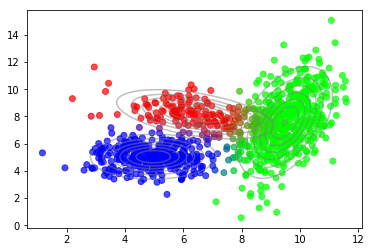

In [8]:
plot_data(X, color=q_best)
plot_densities(X, mu=mu_best, sigma=sigma_best)

### Optimal number of components

Usually, we do not know the optimal number of mixture components a priori. But we can get a hint when plotting the lower bound vs. the number of mixture components.

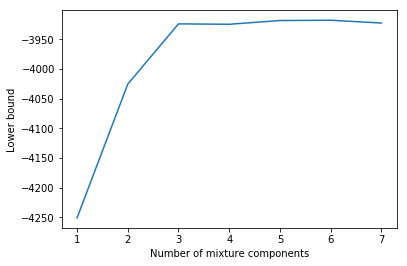

In [9]:
import matplotlib.pyplot as plt

Cs = range(1, 8)
lbs = []

for C in Cs:
    lb = train(X, C)[-1]
    lbs.append(lb)
    
plt.plot(Cs, lbs)
plt.xlabel('Number of mixture components')
plt.ylabel('Lower bound');

There is a strong increase in the lower bound value until $C = 3$ and then the lower bound more or less doesn't increase any more. With more components there are of course more options to overfit but the simplest model that reaches a relatively high lower bound value is a GMM with 3 components. This is exactly the number of components used to generate the data.

A more principled approach to determine the optimal number of components requires a Bayesian treatment of model parameters. In this case the lower bound would also take into account model complexity and we would see decreasing lower bound values for $C \gt 3$ and a maximum at $C = 3$. For details see section 10.2.4 in \[1\].

### Implementation with scikit-learn

The low-level implementation above was just for illustration purposes. Scikit-learn already comes with a `GaussianMixture` class that can be readily used.

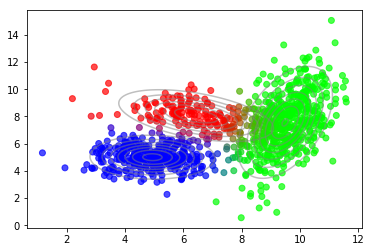

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(X)

plot_data(X, color=gmm.predict_proba(X))
plot_densities(X, mu=gmm.means_, sigma=gmm.covariances_)

The results are very similar. The differences come from different random initializations. Also, plotting the lower bound vs. the number of mixture components reproduces our previous findings.

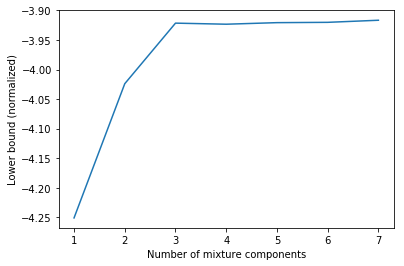

In [11]:
Cs = range(1, 8)
lbs = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    lbs.append(gmm.lower_bound_)
    
plt.plot(Cs, lbs)
plt.xlabel('Number of mixture components')
plt.ylabel('Lower bound (normalized)');

The lower bound values obtained via `gmm.lower_bound_` are normalized i.e. divided by $N = 1000$ in this example.

## Conclusion

Inference of latent variables and estimation of parameters in GMMs is an example of exact inference. The exact posterior can be obtained in the E-step and analytical solutions exist for parameter MLE in the M-step. But for many models of practical interest, exact inference is not possible and approximate inference methods must be used. *Variational inference* is one of them and will be covered in [part 2](latent_variable_models_part_2.ipynb), together with a *variational autoencoder* as application example. 

## References

\[1\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732) ([PDF](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)), Chapter 9.  
\[2\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapter 11.  
